In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [19]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

C:\Users\Colli\AppData\Local\Temp\ipykernel_19020\3555078317.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [21]:
# Print all of the classes mapped to the Base
Base.classes.keys()


['measurement', 'station']

In [8]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurment = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [18]:
# Find the most recent date in the data set.
most_recent = session.query(Measurment).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x19ce0874ac0>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'id': 1,
 'date': '2010-01-01'}

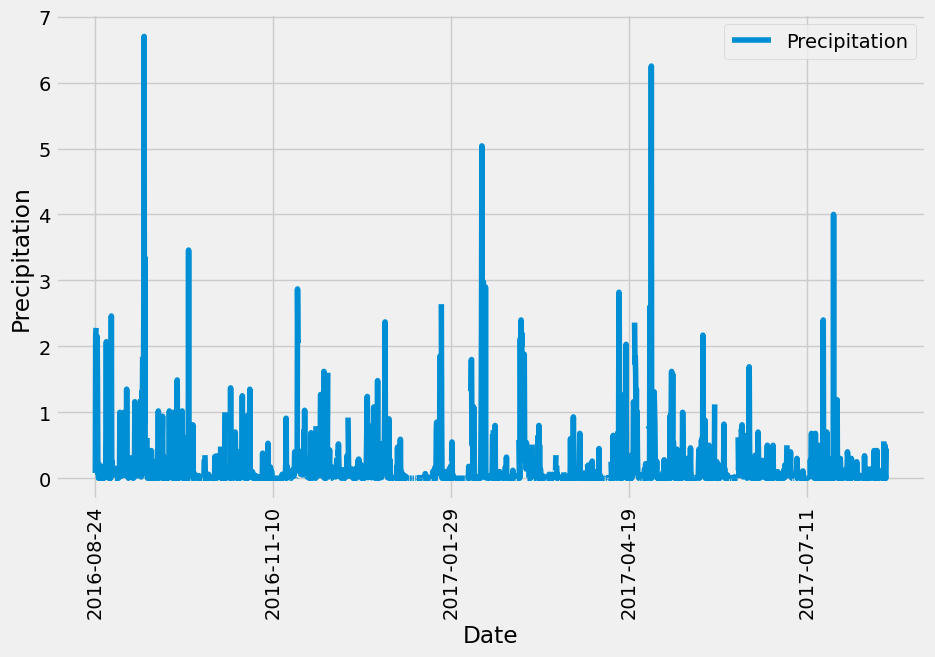

In [46]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')


# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
precip_df = precip_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.set_index('date' , inplace=True)
precip_df.plot(figsize=(10, 6), rot=90)
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.legend(['Precipitation'])
plt.show()

In [32]:
# Use Pandas to calculate the summary statistics for the precipitation data
count = precip_df['precipitation'].count()
mean = precip_df['precipitation'].mean()
std_dev = precip_df['precipitation'].std()
minimum = precip_df['precipitation'].min()
percentile_25 = precip_df['precipitation'].quantile(0.25)
median = precip_df['precipitation'].median()
percentile_75 = precip_df['precipitation'].quantile(0.75)
maximum = precip_df['precipitation'].max()

# Create a DataFrame to display these statistics
summary_stats_df = pd.DataFrame({
    'Statistic': ['Count', 'Mean', 'Standard Deviation', 'Min', '25th Percentile', 'Median', '75th Percentile', 'Max'],
    'Value': [count, mean, std_dev, minimum, percentile_25, median, percentile_75, maximum]
})

print("Summary Statistics for Precipitation Data:")
print(summary_stats_df)

Summary Statistics for Precipitation Data:
            Statistic        Value
0               Count  2015.000000
1                Mean     0.176462
2  Standard Deviation     0.460288
3                 Min     0.000000
4     25th Percentile     0.000000
5              Median     0.020000
6     75th Percentile     0.130000
7                 Max     6.700000


# Exploratory Station Analysis

In [33]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [35]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [39]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()

most_active_station_id = most_active_station.station

temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station_id).all()
# Extract the results
lowest_temp = temperature_stats[0][0]
highest_temp = temperature_stats[0][1]
average_temp = temperature_stats[0][2]

most_active_station_id, lowest_temp, highest_temp, average_temp

('USC00519281', 54.0, 85.0, 71.66378066378067)

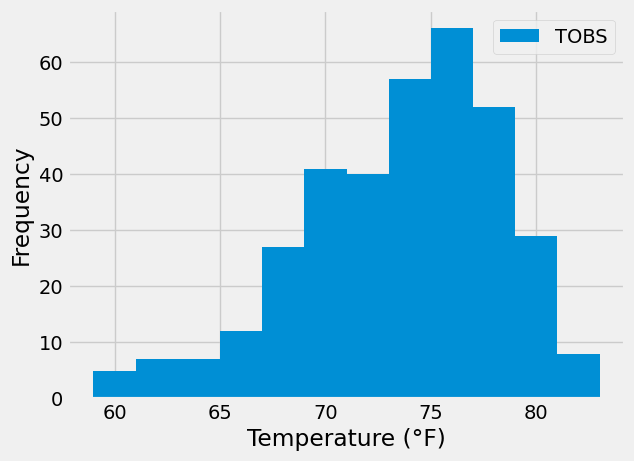

In [48]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

#Save the query results as a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['date', 'temperature'])
plt.hist(temperature_df['temperature'], bins=12)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.legend(['TOBS'])
plt.show()


# Close Session

In [45]:
# Close Session
session.close()
